In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import os

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [3]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# Data Visualization
import plotly.express as px

In [5]:
import sys
from tqdm import tqdm
import time
import copy

In [6]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            #T.RandomHorizontalFlip(),
            #T.RandomVerticalFlip(),
            #T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.20),
            #T.RandomRotation(degrees=(-45, 45)),
            #T.RandomResizedCrop(size=(384, 384), scale=(0.8, 1.0), ratio=(0.75, 1.3333)),
            #T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10)),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet means and standard deviations
    # T.RandomErasing(p=0.2, value='random')  # You can uncomment this line if needed
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [8]:
dataset_path = "/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/"

In [9]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [10]:
classes = get_classes("/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/")

In [11]:
# Get Class Names
class_names = sorted(os.listdir(dataset_path))
n_classes = len(class_names)

# Show
print(f"Class Names : {class_names}")
print(f"Number of Classes  : {n_classes}")

Class Names : ['Benign', 'Early', 'Pre', 'Pro']
Number of Classes  : 4


In [13]:
# Calculate class distribution
class_dis = [len(os.listdir(dataset_path + name)) for name in class_names]
class_dis

[302, 591, 577, 482]

In [14]:
# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [16]:
pred_dataset_path = "/kaggle/input/all-dataset2-splitted/ALL_Splitted/test/"
# Calculate class distribution
class_dis = [len(os.listdir(pred_dataset_path + name)) for name in class_names]

# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Prediction Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [17]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [18]:
print(len(train_loader), len(val_loader), len(test_loader))

61 21 21


In [19]:
print(train_data_len, valid_data_len, test_data_len)

1952 649 655


In [20]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [59]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm

#timm.list_models('**')

model = timm.create_model('mobilenetv2_100', pretrained=True)

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [60]:
print(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedR

In [61]:
import torch.nn as nn

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=4, bias=True)
)


In [62]:
criterion =  nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [63]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
!pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, criterion, optimizer, scheduler, num_epochs=100, patience=500):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improvement_count = 0

    val_true_labels = []
    val_pred_labels = []
    val_pred_probs = []
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val':
                    val_true_labels += labels.tolist()
                    val_pred_labels += preds.tolist()
                    val_pred_probs += torch.softmax(outputs, dim=1).tolist()

            if phase == 'train':
                train_loss_history.append(running_loss / dataset_sizes[phase])
            else:
                val_loss_history.append(running_loss / dataset_sizes[phase])

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, running_loss / dataset_sizes[phase], epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
                no_improvement_count = 0
            elif phase == 'val':
                no_improvement_count += 1

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

        print()

        if no_improvement_count >= patience:
            print(f"No improvement in validation accuracy for {no_improvement_count} epochs. Early stopping...")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)


    # Calculate confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels)
    f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
    sensitivity = confusion_mat.diagonal() / confusion_mat.sum(axis=1)
    specificity = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
    accuracy = np.sum(np.diag(confusion_mat)) / np.sum(confusion_mat)
    true_positives = np.diag(confusion_mat)
    true_negatives = np.sum(confusion_mat) - (np.sum(true_positives) + np.sum(confusion_mat.sum(axis=0)) - np.sum(true_positives))
    false_positives = confusion_mat.sum(axis=0) - true_positives
    false_negatives = confusion_mat.sum(axis=1) - true_positives
    kappa = cohen_kappa_score(val_true_labels, val_pred_labels)

    # Print confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    print("Confusion Matrix:")
    print(confusion_mat)
    print("F1 Score: {:.4f}".format(f1))
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("Accuracy: {:.4f}".format(accuracy))
    print("True Positives:", true_positives)
    print("True Negatives:", true_negatives)
    print("False Positives:", false_positives)
    print("False Negatives:", false_negatives)
    print("Cohen's Kappa:", kappa)


    # Print classification report
    target_names = [str(i) for i in range(len(classes))]
    print(classification_report(val_true_labels, val_pred_labels, target_names=target_names))
    
    
    
    # Set Seaborn style
    sns.set(style="darkgrid")
    # Plot accuracy curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(train_acc_history) + 1), y=train_acc_history, label='Train', linestyle='-', color='#2C5D63')
    sns.lineplot(x=range(1, len(val_acc_history) + 1), y=val_acc_history, label='Validation', linestyle='-', color='#6C5F5B')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(train_loss_history) + 1), y=train_loss_history, label='Train', linestyle='-', color='#2C5D63')
    sns.lineplot(x=range(1, len(val_loss_history) + 1), y=val_loss_history, label='Validation', linestyle='-', color='#6C5F5B')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels, labels=np.arange(len(classes)))
    # Plot customized confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap="YlGn", linewidths=.5, square=True, cbar=False,
                xticklabels=classes, yticklabels=classes)
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')
    
    plt.tight_layout()
    plt.show()

Epoch 0/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.99it/s]


train Loss: 0.2590 Acc: 0.9252


100%|██████████| 21/21 [00:01<00:00, 15.31it/s]


val Loss: 0.0876 Acc: 0.9707

Epoch 1/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.27it/s]


train Loss: 0.0888 Acc: 0.9657


100%|██████████| 21/21 [00:01<00:00, 15.21it/s]


val Loss: 0.0894 Acc: 0.9723

Epoch 2/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.38it/s]


train Loss: 0.0520 Acc: 0.9836


100%|██████████| 21/21 [00:01<00:00, 15.81it/s]


val Loss: 0.0484 Acc: 0.9800

Epoch 3/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.61it/s]


train Loss: 0.0341 Acc: 0.9887


100%|██████████| 21/21 [00:01<00:00, 15.46it/s]


val Loss: 0.0600 Acc: 0.9769

Epoch 4/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.97it/s]


train Loss: 0.0292 Acc: 0.9877


100%|██████████| 21/21 [00:01<00:00, 15.52it/s]


val Loss: 0.0614 Acc: 0.9753

Epoch 5/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.77it/s]


train Loss: 0.0394 Acc: 0.9872


100%|██████████| 21/21 [00:01<00:00, 15.34it/s]


val Loss: 0.0459 Acc: 0.9846

Epoch 6/99
----------


100%|██████████| 61/61 [00:03<00:00, 19.08it/s]


train Loss: 0.0311 Acc: 0.9908


100%|██████████| 21/21 [00:01<00:00, 16.15it/s]


val Loss: 0.0591 Acc: 0.9861

Epoch 7/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.86it/s]


train Loss: 0.0128 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 15.63it/s]


val Loss: 0.0414 Acc: 0.9877

Epoch 8/99
----------


100%|██████████| 61/61 [00:03<00:00, 19.12it/s]


train Loss: 0.0263 Acc: 0.9898


100%|██████████| 21/21 [00:01<00:00, 16.06it/s]


val Loss: 0.0398 Acc: 0.9861

Epoch 9/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.73it/s]


train Loss: 0.0481 Acc: 0.9805


100%|██████████| 21/21 [00:01<00:00, 15.16it/s]


val Loss: 0.0711 Acc: 0.9784

Epoch 10/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.10it/s]


train Loss: 0.0130 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 15.72it/s]


val Loss: 0.0718 Acc: 0.9800

Epoch 11/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.89it/s]


train Loss: 0.0150 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 15.98it/s]


val Loss: 0.0307 Acc: 0.9877

Epoch 12/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.74it/s]


train Loss: 0.0107 Acc: 0.9964


100%|██████████| 21/21 [00:01<00:00, 16.04it/s]


val Loss: 0.0434 Acc: 0.9892

Epoch 13/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.93it/s]


train Loss: 0.0359 Acc: 0.9908


100%|██████████| 21/21 [00:01<00:00, 16.06it/s]


val Loss: 0.0387 Acc: 0.9846

Epoch 14/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.43it/s]


train Loss: 0.0267 Acc: 0.9918


100%|██████████| 21/21 [00:01<00:00, 15.88it/s]


val Loss: 0.0453 Acc: 0.9877

Epoch 15/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.80it/s]


train Loss: 0.0165 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 15.78it/s]


val Loss: 0.0781 Acc: 0.9800

Epoch 16/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.76it/s]


train Loss: 0.0062 Acc: 0.9985


100%|██████████| 21/21 [00:01<00:00, 15.79it/s]


val Loss: 0.0731 Acc: 0.9800

Epoch 17/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.67it/s]


train Loss: 0.0308 Acc: 0.9913


100%|██████████| 21/21 [00:01<00:00, 15.58it/s]


val Loss: 0.0793 Acc: 0.9753

Epoch 18/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.70it/s]


train Loss: 0.0539 Acc: 0.9836


100%|██████████| 21/21 [00:01<00:00, 15.90it/s]


val Loss: 0.1053 Acc: 0.9692

Epoch 19/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.70it/s]


train Loss: 0.0360 Acc: 0.9851


100%|██████████| 21/21 [00:01<00:00, 16.04it/s]


val Loss: 0.0493 Acc: 0.9846

Epoch 20/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.99it/s]


train Loss: 0.0119 Acc: 0.9949


100%|██████████| 21/21 [00:01<00:00, 15.89it/s]


val Loss: 0.0509 Acc: 0.9877

Epoch 21/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.83it/s]


train Loss: 0.0219 Acc: 0.9944


100%|██████████| 21/21 [00:01<00:00, 16.02it/s]


val Loss: 0.0479 Acc: 0.9877

Epoch 22/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.90it/s]


train Loss: 0.0063 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.65it/s]


val Loss: 0.0326 Acc: 0.9908

Epoch 23/99
----------


100%|██████████| 61/61 [00:03<00:00, 19.13it/s]


train Loss: 0.0052 Acc: 0.9985


100%|██████████| 21/21 [00:01<00:00, 15.89it/s]


val Loss: 0.0505 Acc: 0.9846

Epoch 24/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.06it/s]


train Loss: 0.0105 Acc: 0.9949


100%|██████████| 21/21 [00:01<00:00, 15.62it/s]


val Loss: 0.0591 Acc: 0.9861

Epoch 25/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.69it/s]


train Loss: 0.0080 Acc: 0.9964


100%|██████████| 21/21 [00:01<00:00, 14.96it/s]


val Loss: 0.0327 Acc: 0.9861

Epoch 26/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.67it/s]


train Loss: 0.0130 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 15.27it/s]


val Loss: 0.0333 Acc: 0.9892

Epoch 27/99
----------


100%|██████████| 61/61 [00:03<00:00, 19.07it/s]


train Loss: 0.0167 Acc: 0.9949


100%|██████████| 21/21 [00:01<00:00, 15.81it/s]


val Loss: 0.0881 Acc: 0.9784

Epoch 28/99
----------


100%|██████████| 61/61 [00:03<00:00, 19.24it/s]


train Loss: 0.0218 Acc: 0.9933


100%|██████████| 21/21 [00:01<00:00, 16.08it/s]


val Loss: 0.0548 Acc: 0.9831

Epoch 29/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.83it/s]


train Loss: 0.0097 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 16.25it/s]


val Loss: 0.0352 Acc: 0.9861

Epoch 30/99
----------


100%|██████████| 61/61 [00:03<00:00, 19.01it/s]


train Loss: 0.0121 Acc: 0.9949


100%|██████████| 21/21 [00:01<00:00, 16.00it/s]


val Loss: 0.0413 Acc: 0.9861

Epoch 31/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.94it/s]


train Loss: 0.0217 Acc: 0.9933


100%|██████████| 21/21 [00:01<00:00, 15.84it/s]


val Loss: 0.0401 Acc: 0.9877

Epoch 32/99
----------


100%|██████████| 61/61 [00:03<00:00, 15.89it/s]


train Loss: 0.0373 Acc: 0.9913


100%|██████████| 21/21 [00:01<00:00, 10.52it/s]


val Loss: 0.0544 Acc: 0.9815

Epoch 33/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.85it/s]


train Loss: 0.0382 Acc: 0.9908


100%|██████████| 21/21 [00:01<00:00, 15.98it/s]


val Loss: 0.0382 Acc: 0.9892

Epoch 34/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.71it/s]


train Loss: 0.0056 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.79it/s]


val Loss: 0.0648 Acc: 0.9831

Epoch 35/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.24it/s]


train Loss: 0.0110 Acc: 0.9974


100%|██████████| 21/21 [00:01<00:00, 15.62it/s]


val Loss: 0.0349 Acc: 0.9861

Epoch 36/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.80it/s]


train Loss: 0.0270 Acc: 0.9908


100%|██████████| 21/21 [00:01<00:00, 15.78it/s]


val Loss: 0.0652 Acc: 0.9800

Epoch 37/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.00it/s]


train Loss: 0.0366 Acc: 0.9877


100%|██████████| 21/21 [00:01<00:00, 14.27it/s]


val Loss: 0.0636 Acc: 0.9877

Epoch 38/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.81it/s]


train Loss: 0.0493 Acc: 0.9892


100%|██████████| 21/21 [00:01<00:00, 15.30it/s]


val Loss: 0.1266 Acc: 0.9692

Epoch 39/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.07it/s]


train Loss: 0.0254 Acc: 0.9903


100%|██████████| 21/21 [00:01<00:00, 15.42it/s]


val Loss: 0.0699 Acc: 0.9877

Epoch 40/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.41it/s]


train Loss: 0.0197 Acc: 0.9928


100%|██████████| 21/21 [00:01<00:00, 16.04it/s]


val Loss: 0.0526 Acc: 0.9908

Epoch 41/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.47it/s]


train Loss: 0.0096 Acc: 0.9974


100%|██████████| 21/21 [00:01<00:00, 15.73it/s]


val Loss: 0.0925 Acc: 0.9784

Epoch 42/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.63it/s]


train Loss: 0.0212 Acc: 0.9928


100%|██████████| 21/21 [00:01<00:00, 13.40it/s]


val Loss: 0.0544 Acc: 0.9861

Epoch 43/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.09it/s]


train Loss: 0.0031 Acc: 0.9990


100%|██████████| 21/21 [00:01<00:00, 15.61it/s]


val Loss: 0.0914 Acc: 0.9831

Epoch 44/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.42it/s]


train Loss: 0.0092 Acc: 0.9974


100%|██████████| 21/21 [00:01<00:00, 15.16it/s]


val Loss: 0.0599 Acc: 0.9892

Epoch 45/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.57it/s]


train Loss: 0.0038 Acc: 0.9990


100%|██████████| 21/21 [00:01<00:00, 15.13it/s]


val Loss: 0.0547 Acc: 0.9892

Epoch 46/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.27it/s]


train Loss: 0.0132 Acc: 0.9964


100%|██████████| 21/21 [00:01<00:00, 15.16it/s]


val Loss: 0.0456 Acc: 0.9938

Epoch 47/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.34it/s]


train Loss: 0.0059 Acc: 0.9969


100%|██████████| 21/21 [00:01<00:00, 15.39it/s]


val Loss: 0.0489 Acc: 0.9877

Epoch 48/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.96it/s]


train Loss: 0.0074 Acc: 0.9969


100%|██████████| 21/21 [00:01<00:00, 14.99it/s]


val Loss: 0.0475 Acc: 0.9908

Epoch 49/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.31it/s]


train Loss: 0.0029 Acc: 0.9995


100%|██████████| 21/21 [00:01<00:00, 15.75it/s]


val Loss: 0.0513 Acc: 0.9846

Epoch 50/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.58it/s]


train Loss: 0.0030 Acc: 0.9985


100%|██████████| 21/21 [00:01<00:00, 15.83it/s]


val Loss: 0.1097 Acc: 0.9784

Epoch 51/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.22it/s]


train Loss: 0.0142 Acc: 0.9964


100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


val Loss: 0.0494 Acc: 0.9846

Epoch 52/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.27it/s]


train Loss: 0.0105 Acc: 0.9969


100%|██████████| 21/21 [00:01<00:00, 15.43it/s]


val Loss: 0.0855 Acc: 0.9815

Epoch 53/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.46it/s]


train Loss: 0.0205 Acc: 0.9939


100%|██████████| 21/21 [00:01<00:00, 15.51it/s]


val Loss: 0.0892 Acc: 0.9784

Epoch 54/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.36it/s]


train Loss: 0.0266 Acc: 0.9928


100%|██████████| 21/21 [00:01<00:00, 15.53it/s]


val Loss: 0.0833 Acc: 0.9831

Epoch 55/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.60it/s]


train Loss: 0.0110 Acc: 0.9959


100%|██████████| 21/21 [00:01<00:00, 15.80it/s]


val Loss: 0.0494 Acc: 0.9892

Epoch 56/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.97it/s]


train Loss: 0.0063 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.98it/s]


val Loss: 0.0554 Acc: 0.9831

Epoch 57/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.62it/s]


train Loss: 0.0292 Acc: 0.9933


100%|██████████| 21/21 [00:01<00:00, 12.31it/s]


val Loss: 0.0945 Acc: 0.9815

Epoch 58/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.56it/s]


train Loss: 0.0094 Acc: 0.9964


100%|██████████| 21/21 [00:01<00:00, 15.89it/s]


val Loss: 0.0661 Acc: 0.9877

Epoch 59/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.81it/s]


train Loss: 0.0087 Acc: 0.9974


100%|██████████| 21/21 [00:01<00:00, 15.41it/s]


val Loss: 0.0919 Acc: 0.9831

Epoch 60/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.59it/s]


train Loss: 0.0067 Acc: 0.9974


100%|██████████| 21/21 [00:01<00:00, 15.72it/s]


val Loss: 0.0512 Acc: 0.9861

Epoch 61/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.09it/s]


train Loss: 0.0215 Acc: 0.9959


100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


val Loss: 0.0725 Acc: 0.9769

Epoch 62/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.39it/s]


train Loss: 0.0155 Acc: 0.9944


100%|██████████| 21/21 [00:01<00:00, 15.63it/s]


val Loss: 0.0634 Acc: 0.9815

Epoch 63/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.58it/s]


train Loss: 0.0057 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.26it/s]


val Loss: 0.0751 Acc: 0.9861

Epoch 64/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.70it/s]


train Loss: 0.0144 Acc: 0.9964


100%|██████████| 21/21 [00:01<00:00, 15.00it/s]


val Loss: 0.0794 Acc: 0.9815

Epoch 65/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.73it/s]


train Loss: 0.0075 Acc: 0.9985


100%|██████████| 21/21 [00:01<00:00, 15.51it/s]


val Loss: 0.0532 Acc: 0.9877

Epoch 66/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.56it/s]


train Loss: 0.0239 Acc: 0.9928


100%|██████████| 21/21 [00:01<00:00, 15.05it/s]


val Loss: 0.0696 Acc: 0.9892

Epoch 67/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.52it/s]


train Loss: 0.0130 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.87it/s]


val Loss: 0.1220 Acc: 0.9815

Epoch 68/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.73it/s]


train Loss: 0.0176 Acc: 0.9949


100%|██████████| 21/21 [00:01<00:00, 15.06it/s]


val Loss: 0.1688 Acc: 0.9769

Epoch 69/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.83it/s]


train Loss: 0.0053 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.81it/s]


val Loss: 0.0838 Acc: 0.9892

Epoch 70/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.70it/s]


train Loss: 0.0049 Acc: 0.9974


100%|██████████| 21/21 [00:01<00:00, 15.42it/s]


val Loss: 0.0802 Acc: 0.9892

Epoch 71/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.34it/s]


train Loss: 0.0091 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 15.44it/s]


val Loss: 0.0624 Acc: 0.9831

Epoch 72/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.77it/s]


train Loss: 0.0138 Acc: 0.9949


100%|██████████| 21/21 [00:01<00:00, 15.00it/s]


val Loss: 0.1363 Acc: 0.9753

Epoch 73/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.52it/s]


train Loss: 0.0078 Acc: 0.9985


100%|██████████| 21/21 [00:01<00:00, 15.48it/s]


val Loss: 0.0825 Acc: 0.9815

Epoch 74/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.74it/s]


train Loss: 0.0075 Acc: 0.9974


100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


val Loss: 0.0738 Acc: 0.9877

Epoch 75/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.50it/s]


train Loss: 0.0619 Acc: 0.9841


100%|██████████| 21/21 [00:01<00:00, 15.67it/s]


val Loss: 0.1864 Acc: 0.9707

Epoch 76/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.32it/s]


train Loss: 0.0342 Acc: 0.9913


100%|██████████| 21/21 [00:01<00:00, 15.62it/s]


val Loss: 0.0494 Acc: 0.9877

Epoch 77/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.55it/s]


train Loss: 0.0418 Acc: 0.9887


100%|██████████| 21/21 [00:01<00:00, 15.49it/s]


val Loss: 0.0999 Acc: 0.9831

Epoch 78/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.52it/s]


train Loss: 0.0273 Acc: 0.9939


100%|██████████| 21/21 [00:01<00:00, 15.26it/s]


val Loss: 0.1010 Acc: 0.9784

Epoch 79/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.24it/s]


train Loss: 0.0012 Acc: 0.9995


100%|██████████| 21/21 [00:01<00:00, 14.95it/s]


val Loss: 0.0949 Acc: 0.9769

Epoch 80/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.53it/s]


train Loss: 0.0158 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.38it/s]


val Loss: 0.0875 Acc: 0.9861

Epoch 81/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.09it/s]


train Loss: 0.0097 Acc: 0.9959


100%|██████████| 21/21 [00:01<00:00, 15.37it/s]


val Loss: 0.0853 Acc: 0.9861

Epoch 82/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.44it/s]


train Loss: 0.0176 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 15.40it/s]


val Loss: 0.2418 Acc: 0.9492

Epoch 83/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.31it/s]


train Loss: 0.0259 Acc: 0.9944


100%|██████████| 21/21 [00:01<00:00, 15.37it/s]


val Loss: 0.1190 Acc: 0.9846

Epoch 84/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.62it/s]


train Loss: 0.0155 Acc: 0.9954


100%|██████████| 21/21 [00:01<00:00, 12.19it/s]


val Loss: 0.0845 Acc: 0.9892

Epoch 85/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.44it/s]


train Loss: 0.0407 Acc: 0.9903


100%|██████████| 21/21 [00:01<00:00, 15.31it/s]


val Loss: 0.0897 Acc: 0.9769

Epoch 86/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.47it/s]


train Loss: 0.0181 Acc: 0.9969


100%|██████████| 21/21 [00:01<00:00, 15.76it/s]


val Loss: 0.0678 Acc: 0.9908

Epoch 87/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.56it/s]


train Loss: 0.0050 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.39it/s]


val Loss: 0.0755 Acc: 0.9877

Epoch 88/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.68it/s]


train Loss: 0.0047 Acc: 0.9985


100%|██████████| 21/21 [00:01<00:00, 15.96it/s]


val Loss: 0.1198 Acc: 0.9831

Epoch 89/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.63it/s]


train Loss: 0.0070 Acc: 0.9985


100%|██████████| 21/21 [00:01<00:00, 15.33it/s]


val Loss: 0.0534 Acc: 0.9892

Epoch 90/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.14it/s]


train Loss: 0.0032 Acc: 0.9980


100%|██████████| 21/21 [00:01<00:00, 15.25it/s]


val Loss: 0.0978 Acc: 0.9877

Epoch 91/99
----------


100%|██████████| 61/61 [00:03<00:00, 17.52it/s]


train Loss: 0.0062 Acc: 0.9974


100%|██████████| 21/21 [00:01<00:00, 14.29it/s]


val Loss: 0.0878 Acc: 0.9892

Epoch 92/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.64it/s]


train Loss: 0.0135 Acc: 0.9944


100%|██████████| 21/21 [00:01<00:00, 15.80it/s]


val Loss: 0.1137 Acc: 0.9815

Epoch 93/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.70it/s]


train Loss: 0.0038 Acc: 0.9995


100%|██████████| 21/21 [00:01<00:00, 15.24it/s]


val Loss: 0.0699 Acc: 0.9846

Epoch 94/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.47it/s]


train Loss: 0.0093 Acc: 0.9959


100%|██████████| 21/21 [00:01<00:00, 15.77it/s]


val Loss: 0.0681 Acc: 0.9861

Epoch 95/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.56it/s]


train Loss: 0.0015 Acc: 0.9990


100%|██████████| 21/21 [00:01<00:00, 15.95it/s]


val Loss: 0.0689 Acc: 0.9877

Epoch 96/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.54it/s]


train Loss: 0.1496 Acc: 0.9769


100%|██████████| 21/21 [00:01<00:00, 15.29it/s]


val Loss: 0.1347 Acc: 0.9784

Epoch 97/99
----------


100%|██████████| 61/61 [00:03<00:00, 18.89it/s]


train Loss: 0.0301 Acc: 0.9959


100%|██████████| 21/21 [00:01<00:00, 15.95it/s]


val Loss: 0.0725 Acc: 0.9846

Epoch 98/99
----------


100%|██████████| 61/61 [00:03<00:00, 16.82it/s]


train Loss: 0.0183 Acc: 0.9939


100%|██████████| 21/21 [00:01<00:00, 15.92it/s]


val Loss: 0.2811 Acc: 0.9522

Epoch 99/99
----------


100%|██████████| 61/61 [00:03<00:00, 19.02it/s]


train Loss: 0.0529 Acc: 0.9908


100%|██████████| 21/21 [00:01<00:00, 15.24it/s]


val Loss: 0.0868 Acc: 0.9800

Training complete in 7m 52s
Best Val Acc: 0.9938
Confusion Matrix:
[[ 9480   414   103     3]
 [  222 19360    69    49]
 [   22   101 19068     9]
 [   80     3    26 15891]]
F1 Score: 0.9830
Sensitivity (Recall): [0.948      0.98274112 0.993125   0.9931875 ]
Specificity: [0.948      0.98274112 0.993125   0.9931875 ]
Accuracy: 0.9830
True Positives: [ 9480 19360 19068 15891]
True Negatives: 0
False Positives: [324 518 198  61]
False Negatives: [520 340 132 109]
Cohen's Kappa: 0.9769294488611807
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10000
           1       0.97      0.98      0.98     19700
           2       0.99      0.99      0.99     19200
           3       1.00      0.99      0.99     16000

    accuracy                           0.98     64900
   macro avg       0.98      0.98      0.98     64900
weighted avg       0.98      0.98      0.98     64900



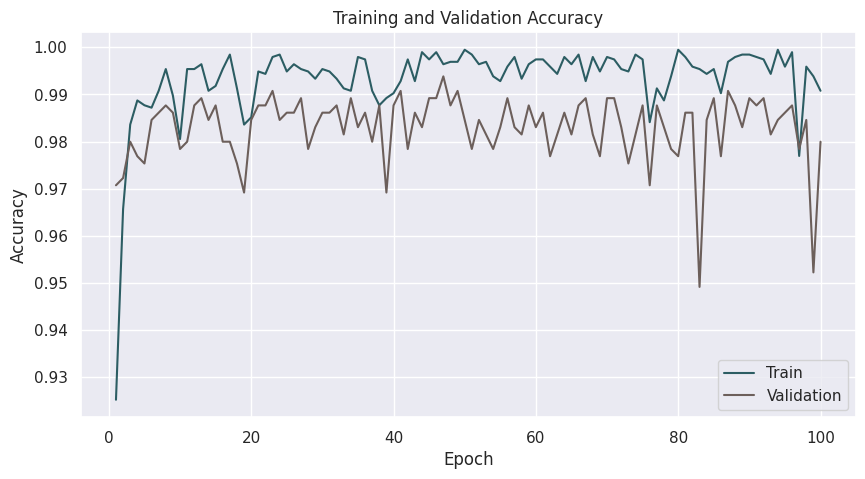

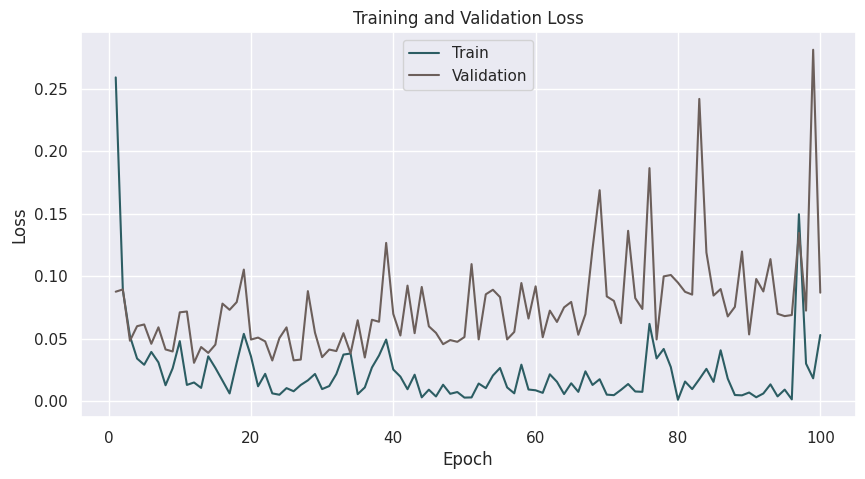

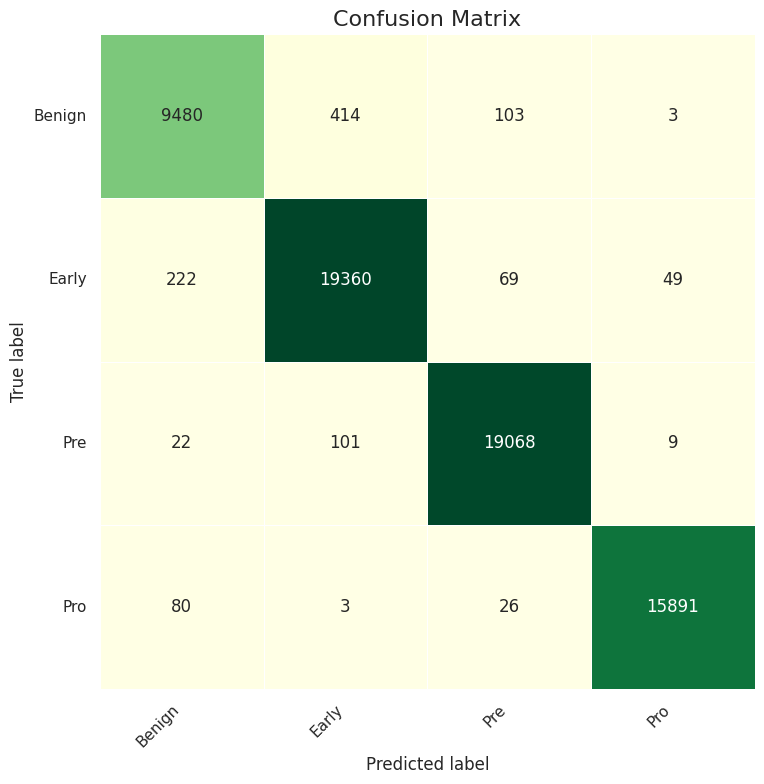

In [64]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler)

example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("/kaggle/working/kvasir_mobilenetv2_E100_2class.pt")

In [68]:
import torch
import numpy as np
from tqdm import tqdm

# Assuming you have defined the 'device', 'classes', 'test_loader', 'criterion', and 'test_data_len' variables

model_path = "/kaggle/working/kvasir_mobilenetv2_E100_2class.pt"
model = torch.jit.load(model_path)
model = model.to(device)

test_loss = 0.0
class_correct = list(0 for _ in range(len(classes)))
class_total = list(0 for _ in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)  # Accumulate the losses

    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Check if the test_data_len is not zero before dividing
if test_data_len > 0:
    test_loss = test_loss / test_data_len
    print('Test Loss: {:.4f}'.format(test_loss))
else:
    print('Test Loss: N/A (test_data_len is zero)')

# Calculate and print accuracy
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))

# Overall accuracy
total_correct = np.sum(class_correct)
total_samples = np.sum(class_total)
if total_samples > 0:
    overall_accuracy = 100. * total_correct / total_samples
    print('\nTest Accuracy : {:.4f} ({}/{})'.format(overall_accuracy, total_correct, total_samples))
else:
    print('Overall Test Accuracy: N/A (total_samples is zero)')


100%|██████████| 21/21 [00:01<00:00, 11.34it/s]

Test Loss: 0.0744
Test Accuracy of Benign: 97% (99/102)
Test Accuracy of Early: 98% (195/197)
Test Accuracy of   Pre: 99% (193/194)
Test Accuracy of   Pro: 99% (161/162)

Test Accuracy : 98.9313 (648/655)
